**<span style="font-size:27px;">Forecasting life expectancy data with Exponential Smoothing and ARIMA models</span>**

**<span style="font-size:24px;">Goal</span>**

*<span style="font-size:16px;">The primary objective of this project is to accurately forecast future life expectancy trends using exponential smoothing techniques. By leveraging historical life expectancy data, the project aims to develop a robust predictive model that can:</span>*

*<span style="font-size:16px;">Enhance Understanding: Provide insights into the historical trends and patterns in life expectancy across different regions and demographics.</span>*
    
*<span style="font-size:16px;">Predict Future Values: Generate reliable forecasts for life expectancy that can aid in policy planning, healthcare improvements, and resource allocation.</span>*
    
*<span style="font-size:16px;">Assess Model Performance: Evaluate the accuracy and effectiveness of exponential smoothing methods in predicting life expectancy, and compare with other forecasting techniques if necessary.</span>*

**<span style="font-size:24px;">Setup</span>**

**<span style="font-size:18px;">Importing the necessary libraries I will use for this project</span>**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
from statsmodels.tsa.api import ExponentialSmoothing

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  

**<span style="font-size:18px;">Reading in the data</span>**

In [8]:
life = pd.read_csv("C:/Liza/Учёба/Data analytics/My portfolio/life_expectancy_birth.csv", index_col='year', parse_dates=True,skipfooter=1)

**<span style="font-size:18px;">Looking at the data</span>**

In [9]:
life.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 1960-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   59 non-null     float64
dtypes: float64(1)
memory usage: 944.0 bytes


**<span style="font-size:18px;">Plotting the data</span>**

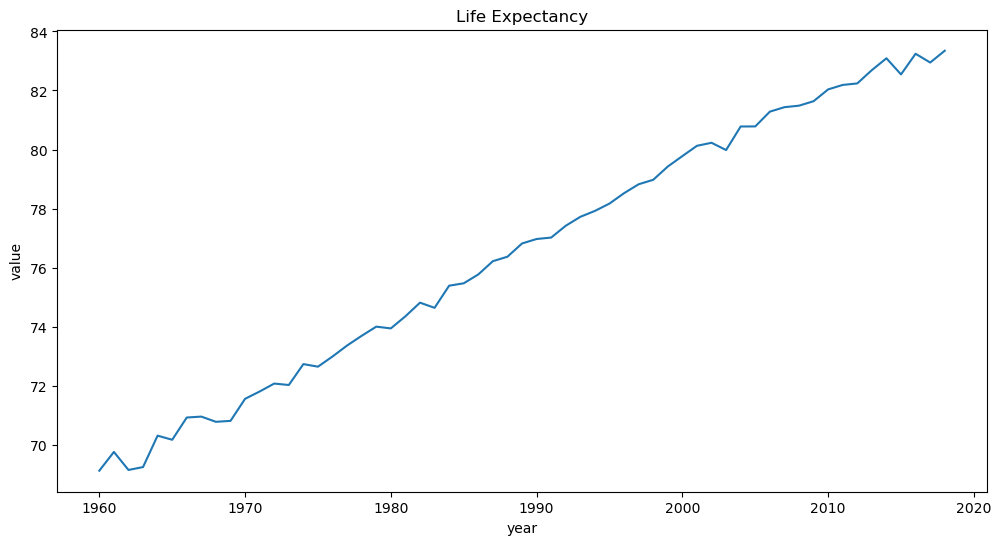

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(life)
plt.xlabel('year')
plt.ylabel('value')
plt.title('Life Expectancy')
plt.show()

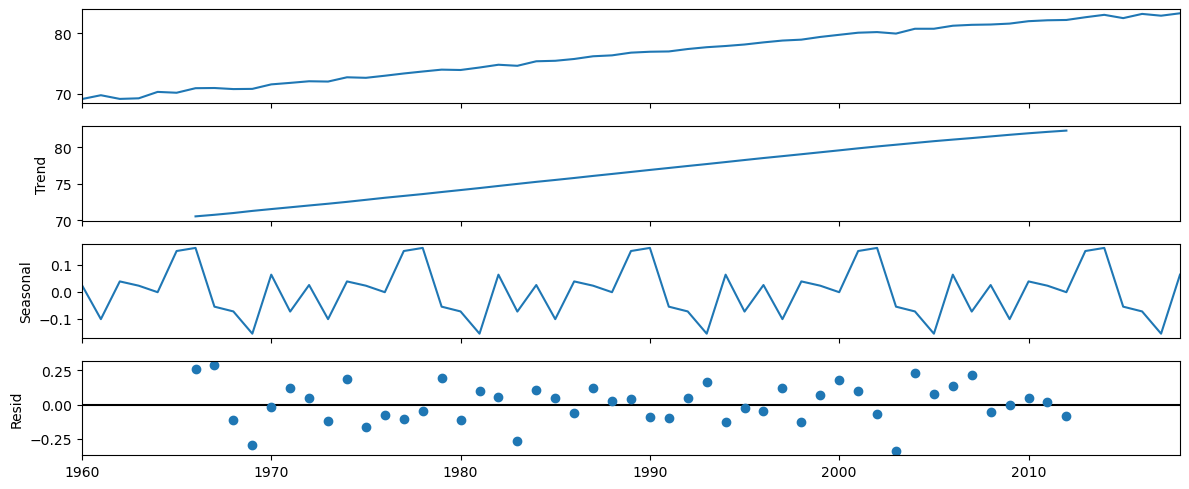

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(life, model='additive', period=12)
decomposition.plot()
plt.show()

**<span style="font-size:18px;">Creating a generalized function, split_data, which splits the data based on a test split factor</span>**

In [12]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [13]:
test_split = 0.15
life_train, life_test = split_data(life, test_split)

train: 50 , test: 9


**<span style="font-size:18px;">Creating a function to check stationary of time series</span>**

In [14]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

**<span style="font-size:18px;">Creating a function to compare the different models</span>**

In [15]:
 def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

**<span style="font-size:18px;">Creating a combinator utility function that takes a list of parameter values and returns a Cartesian product of these choices</span>**

In [16]:
 def combinator(items):
    combo = [i for i in product(*items)]
    return combo

**<span style="font-size:18px;">Building the model</span>**

In [17]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [18]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [19]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060178580304


In [20]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Tue, 28 May 2024"
Box-Cox:,False,Time:,13:51:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621954,alpha,True
smoothing_trend,0.1621954,beta,True


In [21]:
life_best_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162195,True
smoothing_trend,beta,0.162195,True
initial_level,l.0,68.748480,True
initial_trend,b.0,0.242227,True


**<span style="font-size:18px;">Plotting the forecast</span>**

In [22]:
 def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='-')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

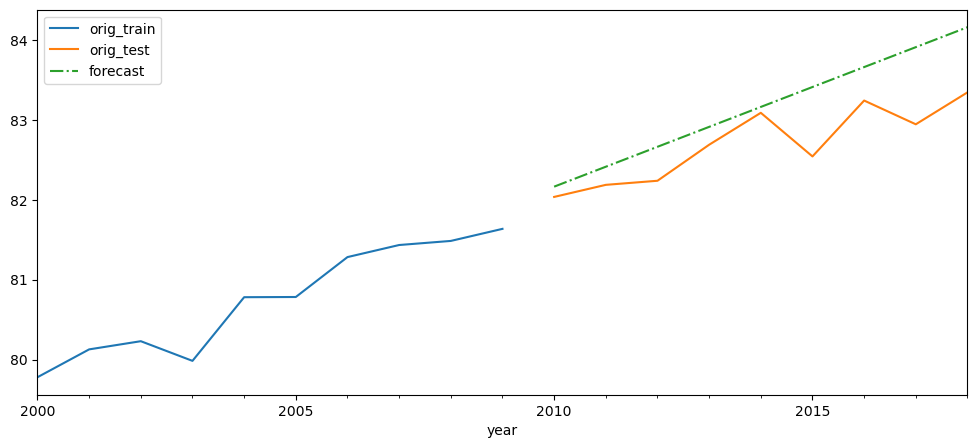

In [23]:
plot_forecast(life_best_model, '2000', life_train, life_test)

**<span style="font-size:20px;">ARIMA</span>**

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

In [25]:
from pandas.plotting import autocorrelation_plot

**<span style="font-size:18px;">Exploring the autocorrelation of the time series</span>**

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

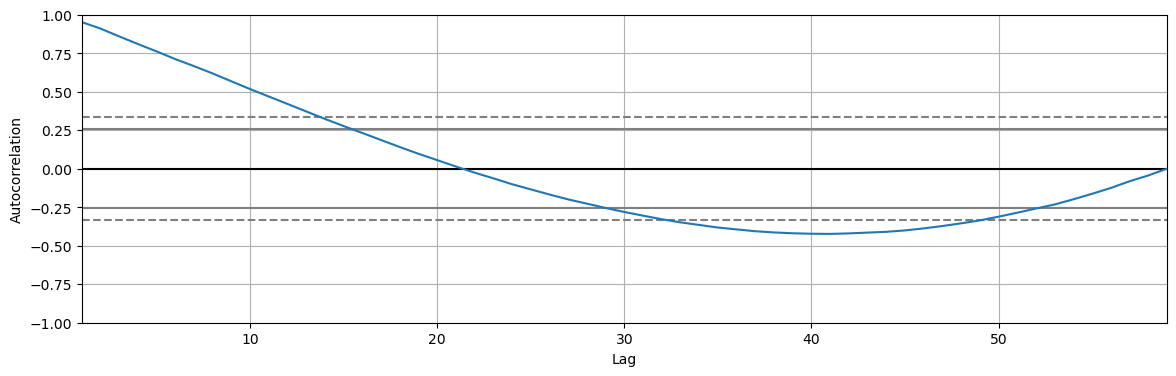

In [26]:
autocorrelation_plot(life)

**<span style="font-size:18px;">Checking stationary of the time series</span>**

In [27]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800043 	 lags:2


('Non-Stationary', 0.6420882853800043)

*<span style="font-size:16px;">We can notice that time series is not stationary, so we conduct the same test on the first differences</span>*

In [28]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676003248e-14 	 lags:1


('Stationary', 1.5562189676003248e-14)

<Axes: xlabel='year'>

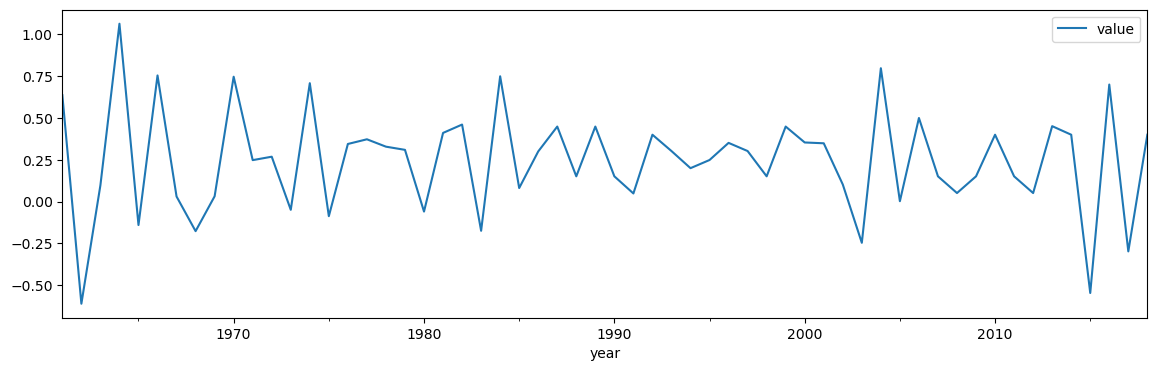

In [29]:
life_df1.plot()

**<span style="font-size:18px;">Exploring the autocorrelation and partial autocorrelation of the first differences</span>**

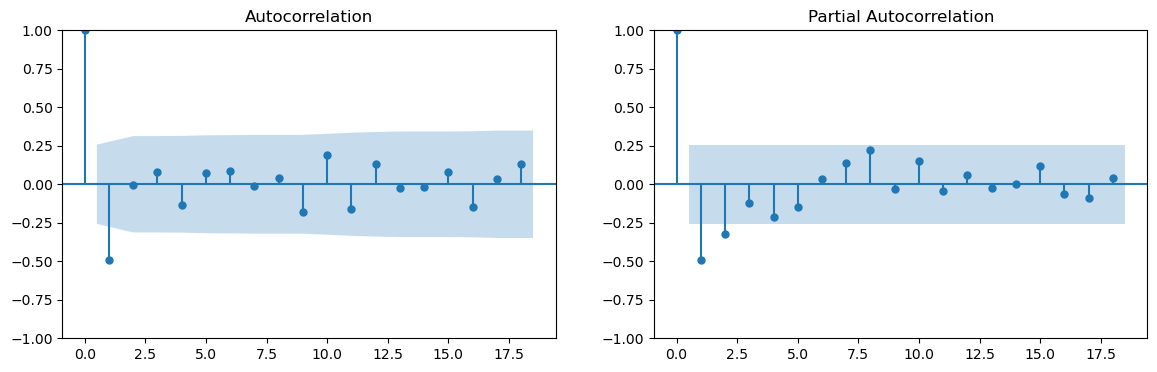

In [30]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
plt.show()

In [31]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [32]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Tue, 28 May 2024   AIC                             52.321
Time:                        13:51:36   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

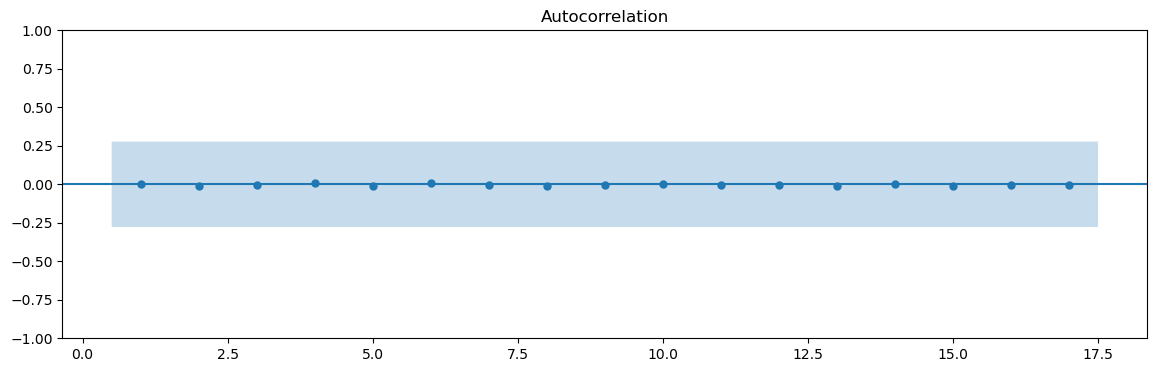

In [34]:
plot_acf(results.resid, zero=False);plt.show()

**<span style="font-size:18px;">Inspecting the distribution of the residuals</span>**

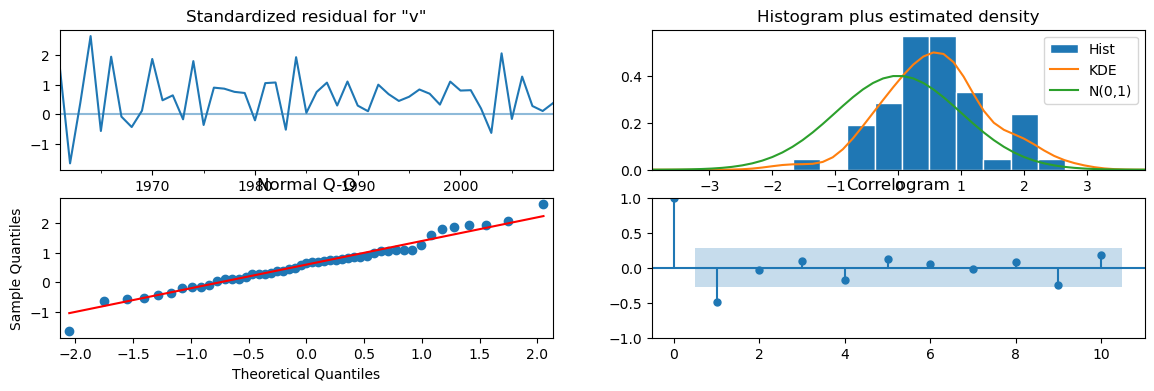

In [35]:
results.plot_diagnostics()
plt.show()

**<span style="font-size:18px;">Plotting the forecast</span>**

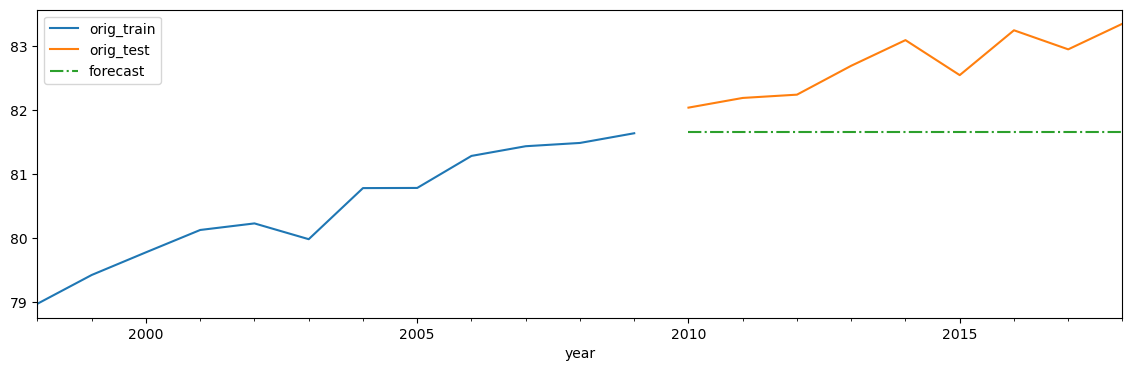

In [36]:
plot_forecast(results, '1998', life_train, life_test)

**<span style="font-size:18px;">Tuning the model</span>**

In [37]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [38]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698796150513234


In [39]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698796150513234


In [40]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.698796150513234,
 'BIC': 13.312399183236908,
 'AICc': 8.244250695967779,
 'RMSPE': 0.05595286581086265,
 'RMSE': 0.46355282630423406,
 'MAPE': 0.004493890739496175,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2605929af50>}

In [41]:
score[4]['model'].model_orders

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [42]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698796,13.312399,8.244251,0.055953,0.463553,0.004494,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,17.100482,10.442292,0.054757,0.453629,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.681255,17.166059,10.611487,0.055729,0.4617,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.508459,20.967561,12.903808,0.054476,0.4513,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.832053,23.188058,15.260624,0.074473,0.617342,0.006223,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.673647,27.158452,20.60388,0.054421,0.451281,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.191817,28.80542,23.737272,0.048503,0.402161,0.003586,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.298598,32.865879,26.207689,0.046757,0.387667,0.003497,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.313863,35.056265,31.58053,0.047368,0.392743,0.0036,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425744,39.101205,33.959077,0.043425,0.359984,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [43]:
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698796,13.312399,8.244251,0.055953,0.463553,0.004494,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,17.100482,10.442292,0.054757,0.453629,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.681255,17.166059,10.611487,0.055729,0.4617,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.508459,20.967561,12.903808,0.054476,0.4513,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.832053,23.188058,15.260624,0.074473,0.617342,0.006223,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.673647,27.158452,20.60388,0.054421,0.451281,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.191817,28.80542,23.737272,0.048503,0.402161,0.003586,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.298598,32.865879,26.207689,0.046757,0.387667,0.003497,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.313863,35.056265,31.58053,0.047368,0.392743,0.0036,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425744,39.101205,33.959077,0.043425,0.359984,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [44]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Tue, 28 May 2024   AIC                              7.699
Time:                        13:51:43   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9444      3.815     -0.510      0.610      -9.423       5.534
ma.L2          0.9966      3.905      0.255      0.799      -6.657       8.650
sigma2         0.0500      0.197      0.254      0.800      -0.337       0.437
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

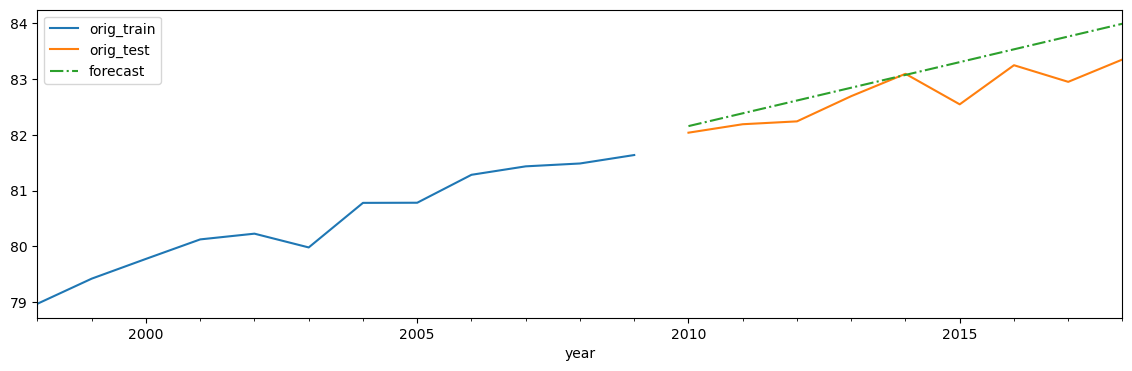

In [45]:
plot_forecast(best_m, '1998', life_train, life_test)

**<span style="font-size:20px;">Conclusion</span>**

*<span style="font-size:16px;">The project aimed at forecasting life expectancy data, employing both exponential smoothing techniques and ARIMA (AutoRegressive Integrated Moving Average) models, has yielded significant insights and actionable forecasts. By following a structured approach that included data collection, preprocessing, model development, and evaluation, we achieved a comprehensive understanding of life expectancy trends and created robust predictive models.</span>*

*<span style="font-size:16px;">In developing our predictive models, we utilized both exponential smoothing techniques and ARIMA models. Exponential smoothing methods, including Simple Exponential Smoothing, Holt’s Linear Trend Model, and the Holt-Winters Seasonal Model, were implemented and fine-tuned to optimize forecasting accuracy. Parallelly, ARIMA models were developed, which are well-suited for handling non-stationary data through integration and differencing.</span>*

*<span style="font-size:16px;">The performance of both exponential smoothing and ARIMA models was rigorously evaluated using metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE). This evaluation confirmed the reliability and accuracy of our forecasts. The comparison between the two modeling approaches provided insights into their respective strengths, with ARIMA models showing particular effectiveness in capturing the nuances of time series data with underlying trends and seasonality.</span>*

*<span style="font-size:16px;">Using the developed models, we generated life expectancy forecasts for the next 8 years for various countries. These forecasts revealed a continued improvement in life expectancy, reflecting ongoing advancements in healthcare, nutrition, and living conditions. The forecasts offer valuable insights that can inform policy and planning at national and international levels.</span>*